# Classification à partir d'un arbre de décision et de forêts aléatoires

On va utiliser le jeu de données Pima Indian Diabetes disponible [là par exemple](https://www.kaggle.com/uciml/pima-indians-diabetes-database). Le dataset est déjà chargé dans l'environnement.

## Import des librairies

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Import des données

In [2]:
data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Visualisation, analyse exploratoire et gestion des éventuels problèmes sur les données

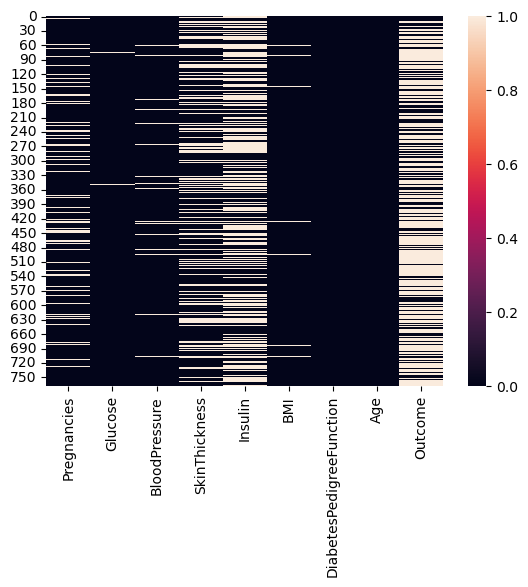

In [6]:
sns.heatmap(data==0);

Il semble que lses valeurs 0 sont en fait les valeurs manquantes. On va donc faire une analyse des na pour ces valeurs.

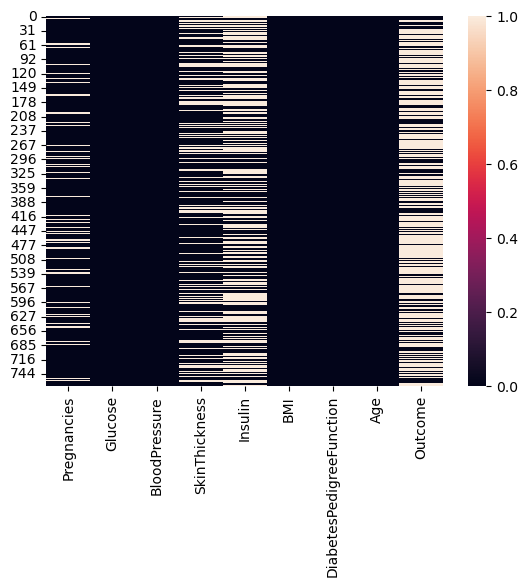

In [11]:
data = data[(data.BMI != 0) & (data.Glucose != 0) & (data.BloodPressure!=0)]
sns.heatmap(data==0);

Pour les 2 autres variables SkinThickness et Insulin, on va regarder si ces variables sont potentiellement importantes pour expliquer le diabète.

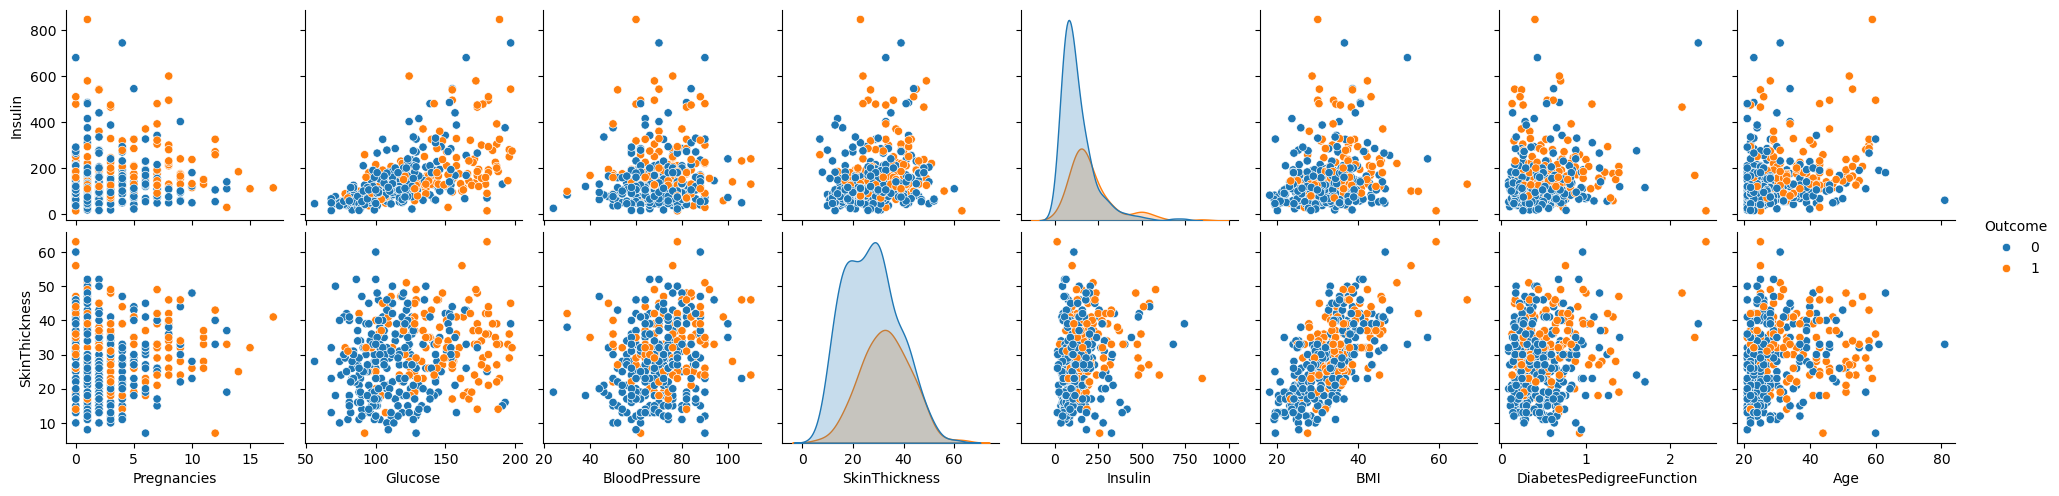

In [15]:
sns.pairplot(data[(data.Insulin!=0) & (data.SkinThickness!=0)], y_vars=['Insulin', 'SkinThickness'], hue='Outcome');

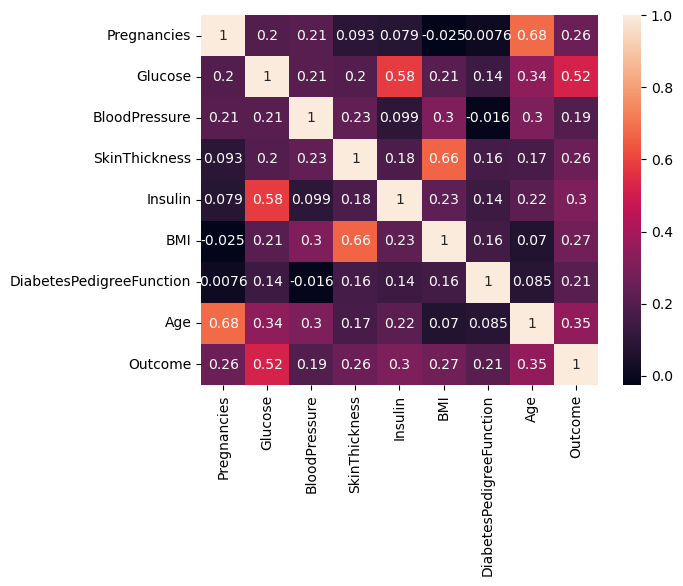

In [17]:
sns.heatmap(data[(data.Insulin!=0) & (data.SkinThickness!=0)].corr(), annot=True);

On va conserver ces varaiables qui semblent importantes et imputer les valeurs manquantes:
- soit on les supprime mais ça fait beaucoup
- soit on impute la moyenne/médiane pour tout le monde mais c'est grossier...
- soit on trouve un moyen d'imputer une valeur plus précise

In [20]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [43]:
var = "SkinThickness"
datareg = data[['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
filtre = (data[var] == 0)
X_nomiss = datareg[~filtre]
y_nomiss = data.loc[~filtre,var]

X_miss = datareg[filtre]

lr = LinearRegression().fit(X_nomiss, y_nomiss)
rf = RandomForestRegressor().fit(X_nomiss, y_nomiss)

valeurs_imputees = lr.predict(X_miss).astype('int')
valeurs_imputees_rf = rf.predict(X_miss).astype('int')

y_pred_nomiss = rf.predict(X_nomiss).astype('int')

rf.score(X_nomiss,y_nomiss), np.mean((y_pred_nomiss-y_nomiss)**2)

(0.9213536837532927, 9.088345864661655)

In [45]:
# fonction pour imputer les données manquantes par la prédiction obtenue avec une régression linéaire
def rf_imputation(var):
    # on conserve uniquement les variables non manquantes et non à imputer et non outcome pour notre modèle
    datareg = data[['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
    
    filtre = (data[var] == 0) # filtre pour identifier les valeurs manquantes de la variable à imputer

    # échantillons d'entraînement du modèle = tous les observations non manquantes sur la variable à imputer
    X_nomiss = datareg[~filtre]
    y_nomiss = data.loc[~filtre, var]

    # Les variables explicatives du modèle d'imputation pour les observations manquantes sur var
    X_miss = datareg[filtre]

    # le random forest
    rf = RandomForestRegressor().fit(X_nomiss, y_nomiss)
    
    return rf.predict(X_miss).astype('int')

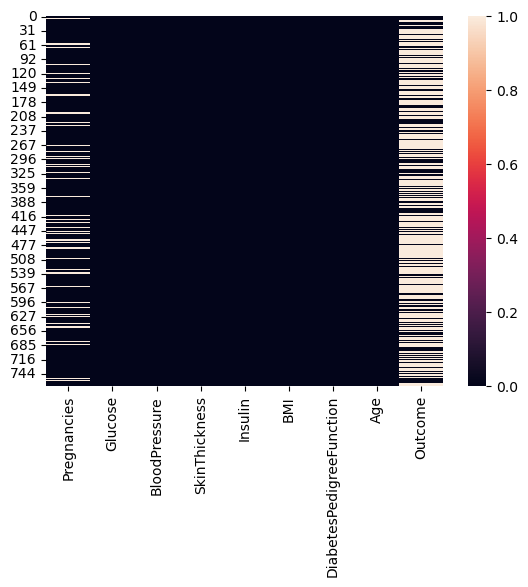

In [48]:
data.loc[data.SkinThickness == 0, 'SkinThickness'] = rf_imputation('SkinThickness')
data.loc[data.Insulin == 0, 'Insulin'] = rf_imputation('Insulin')
sns.heatmap(data == 0);

## Préparation des différents datasets pour la modélisation

In [51]:
X = data.drop('Outcome', axis=1)
y = data.Outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

## Un premier arbre de décision

Créer et entrainer un arbre de décision puis calculer l'accuracy et afficher l'arbre obtenu.

In [54]:
a = DecisionTreeClassifier().fit(X_train, y_train)
a.score(X_train, y_train), a.score(X_test, y_test)

(1.0, 0.6906077348066298)

## Un second arbre de décision

Refaire la même chose en modifiant les paramètres de la classe `DecisionTreeClassifier`, notamment `max_depth` et `criterion`.

In [ ]:
a = DecisionTreeClassifier()
a.fit(X_train, y_train)
a.score(X_train, y_train), a.score(X_test, y_test)

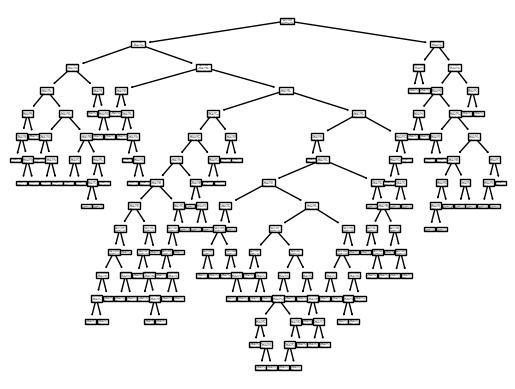

In [57]:
plot_tree(a);

In [61]:
pd.DataFrame(a.feature_importances_,
             columns=['Importance'],
             index=a.feature_names_in_).sort_values('Importance', ascending=False)

,Importance
Glucose,0.273501
Insulin,0.161005
BMI,0.133907
Age,0.110097
DiabetesPedigreeFunction,0.102439
SkinThickness,0.081549
BloodPressure,0.077339
Pregnancies,0.060163


## Un peu de validation croisée pour affiner les hyperparamètres

Utiliser la fonction adéquate pour tester différentes valeurs des paramètres(`max_depth` et `criterion`).

In [62]:
a = DecisionTreeClassifier(max_depth=3, criterion='gini')
a.fit(X_train, y_train)
a.score(X_train, y_train), a.score(X_test, y_test)

(0.7753222836095764, 0.7016574585635359)

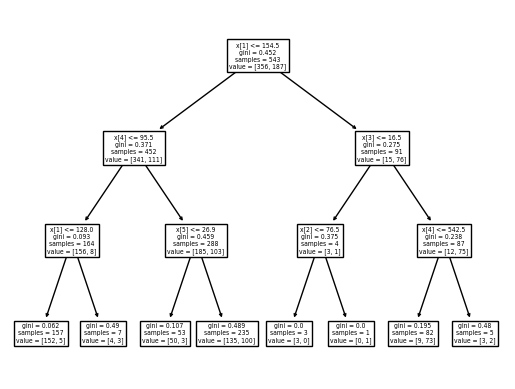

In [63]:
plot_tree(a);

In [64]:
pd.DataFrame(a.feature_importances_,
             columns=['Importance'],
             index=a.feature_names_in_).sort_values('Importance', ascending=False)

,Importance
Glucose,0.588246
Insulin,0.238440
BMI,0.126432
SkinThickness,0.030772
BloodPressure,0.016110
Pregnancies,0.000000
DiabetesPedigreeFunction,0.000000
Age,0.000000


## Et une petite forêt aléatoire pour finir...

In [66]:
rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
rf.fit(X_train, y_train)
rf.score(X_train, y_train), rf.score(X_test, y_test)

(1.0, 0.7403314917127072)

## ...avec validation croisée pour le nombre d'arbres de la forêt

## 

In [69]:
param_grid = {
    'n_estimators':[50, 100, 200],
    'max_depth':list(range(2,8))+[None],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

grid_cv = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, None],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [50, 100, 200]})

In [75]:
#grid_cv.cv_results_

In [73]:
print(f"Meilleurs paramètres sur le jeu d'entraînement {grid_cv.best_params_}")

print("Accuracy des modèles obtenus avec chaque combinaison de paramètres :")
for params, res in zip(grid_cv.cv_results_['params'], grid_cv.cv_results_['mean_test_score']):
    print(f"{params} : {res}")

Meilleurs paramètres sur le jeu d'entraînement {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}
Accuracy des modèles obtenus avec chaque combinaison de paramètres :
{'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 50} : 0.7586868686868687
{'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 100} : 0.7716161616161616
{'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 200} : 0.7697643097643099
{'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 50} : 0.7661616161616162
{'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 100} : 0.7624242424242424
{'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 200} : 0.7642424242424243
{'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'n_estimators': 50} : 0.756902356902357
{'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'n_estimators': 

In [76]:
pd.DataFrame(rf.feature_importances_,
             columns=['Importance'],
             index=a.feature_names_in_).sort_values('Importance', ascending=False)

,Importance
Glucose,0.220977
Insulin,0.177437
BMI,0.143386
Age,0.112160
DiabetesPedigreeFunction,0.100679
SkinThickness,0.094454
BloodPressure,0.076302
Pregnancies,0.074604


## Un petit dernier : Gradient Boosting

Gradient Boosting est une amélioration des forêts aléatoires. Il en existe d'autres, notamment XGBoost pour Extreme Gradient Boosting qui est un mdèle performant dans de nombreux cas. Juste un petit aperçu...